In [9]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'


In [66]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75):
    values = defaultdict(list)

    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    #print(list_folds)
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9])", fold_path)
        fold_nb = int(match[0][-1])
        fold_string=f"fold_{fold_nb}"
        print(fold_string,  end = ' ')

        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                print(f'{tag} {len(vals)}, ',  end = '')
                if tag == 'val_acc':
                    print(f"Max_acc: {max(vals):.3}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                #values[tag].append([])
                pass
        print()
    print()
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_list = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    best_epochs = []
    patt_to_find = 'epoch='
    for fold_ckpt in fold_ckpts:
        idx_beg=fold_ckpt.rfind(patt_to_find)
        idx_end=fold_ckpt[idx_beg+1:].find('_')+idx_beg
        best_epochs.append(int(fold_ckpt[idx_beg+len(patt_to_find):idx_end+1]))
    #print("best ep", hparams_list)
    
    if len(best_epochs) > 0: hparams_list['best_epoch'] = int(np.mean(best_epochs))
    hparams_list.pop('args', None)
        
    return values, hparams_list

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        x_values = x_values if val_cond else values[f'{metric_name}_step']
        #print('max_epochs_real', max_epochs_real, val_epochs_logged)
        max_epochs_real = max(max(x_values)) 
        #max_epochs = min(max_epochs, max_epochs_real)
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        if val_cond:
            metric_log_steps = x_values
            #metric_log_steps = [list(set(el)) for el in metric_log_steps]
        else:
            metric_log_steps = values[f'{metric_name}_step']
        
        for steps, vals in zip(metric_log_steps, values[metric_name]):
            steps = steps[:len(vals)]
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        interp_values[f'{metric_name}_interp_var'] = np.var(temp_lists, axis=0)
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max(max(epochs_values)), interp_values_df.shape[0])
            #print("max val ep: ", max(epochs)) 
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(interp_values_df.shape[0]) * 0.95, '--k', linewidth=1, alpha=0.1)
        
    return ax

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     xlabel='rel_steps', color_patt=None):
    rejected_ckpts=[]
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(20,6)
    f.tight_layout()
    plt.ylim(0,1.1)
    is_labeled = np.zeros(10)
    tot_len_ckpt = len(logs_paths)
    if color_patt == 'discrete':
        cmap = plt.get_cmap('Dark2')
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)
        match=re.search(re.compile("_d([0-9]*)"), ckpt_name)
        depth=int(match.group(1)) 
        match=re.search(re.compile("_b([0-9]*)"), ckpt_name)
        b_len=int(match.group(1)) 

        metric_values, hparams_list = parse_tb_logs(logs_path, metrics_to_plot,
                                                    threshold=threshold)
        if len(list(metric_values)) == 0: 
            rejected_ckpts.append(ckpt_name)
            continue
            
        def create_run_dict(hparams_list, metric_values, ckpt_name):
            hparams_list['name'] = ckpt_name
            hparams_list['eval_steps'] = []
            hparams_list['best_score'] = max(max(metric_values['val_acc']))
            return hparams_list
        
        highscore_table.append(create_run_dict(hparams_list, metric_values, ckpt_name))   
        val_epochs_logged = 'val_epoch' in metric_values.keys()
        if 'epoch' in xlabel and val_epochs_logged:
            x_values = metric_values['val_epoch']
        else:
            x_values = metric_values['val_loss_step']
            if b_len > 0: 
                res=[]
                for fold_vals in x_values:
                    fold_vals.insert(0, 0)
                    res.append([fold_vals[i] - fold_vals[i-1] for i in range(1, len(fold_vals))])
                x_values=res
        
        interp_values = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=x_values,
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)][4]
        if color_patt == None:
            cmap = plt.get_cmap(cm_names[depth - min_d])
            lightness = (hparams_list['hidden_size'] * hparams_list['lr'] / max_h / max_lr) + 0.2
            if depth < 7: lightness += 0.3 
            color = cmap(lightness)
        elif color_patt == 'discrete':
            color = cmap(i/8) #tot_len_ckpt)
            
        label = None
        if plot_legend == 1:
            label = str(ckpt_name[label_pos+1:])
        if plot_legend == 2:
            if not is_labeled[depth-1]: #and lightness > 0.3:
                label = str(f"depth={depth}")
                is_labeled[depth-1] = True
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=x_values, color=color)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return rejected_ckpts, highscore_table

In [67]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
metrics_to_plot = ['val_loss', 'val_acc', 'val_epoch']
max_h = 1400
max_lr = 2.0
min_d = 5


#logged paths : 167 
27127858_2104_1119_synth_um_b1_d6_h25_lr3.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.952 val_epoch 11, 

27149290_2604_1439_synth_um_b0_d5_h25_lr2.0
fold_0 val_loss 124, val_acc 124, Max_acc: 0.637 unsuccessful run
27127788_2104_0758_synth_um_b1_d7_h400_lr2.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.946 val_epoch 23, 

27127860_2104_1119_synth_um_b10_d6_h25_lr3.0
fold_0 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 

27135036_2304_1737_synth_um_b1000_d6_h50_lr1.5
fold_0 val_loss 46, val_acc 46, Max_acc: 0.567 unsuccessful run
27149291_2604_1439_synth_um_b100_d5_h25_lr2.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.691 unsuccessful run
27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
fold_3 val_loss 378, val_acc 378, Max_acc: 0.951 val_epoch 378, 
fold_2 val_loss 335, val_acc 335, Max_acc: 0.954 val_epoch 335, 
fold_0 val_loss 382, val_acc 382, Max_acc: 0.953 val_epoch 382, 
fold_1 val_loss 376, val_acc 376, Max_acc: 0.956 val_epoch 376, 

27146504_2504_1416_

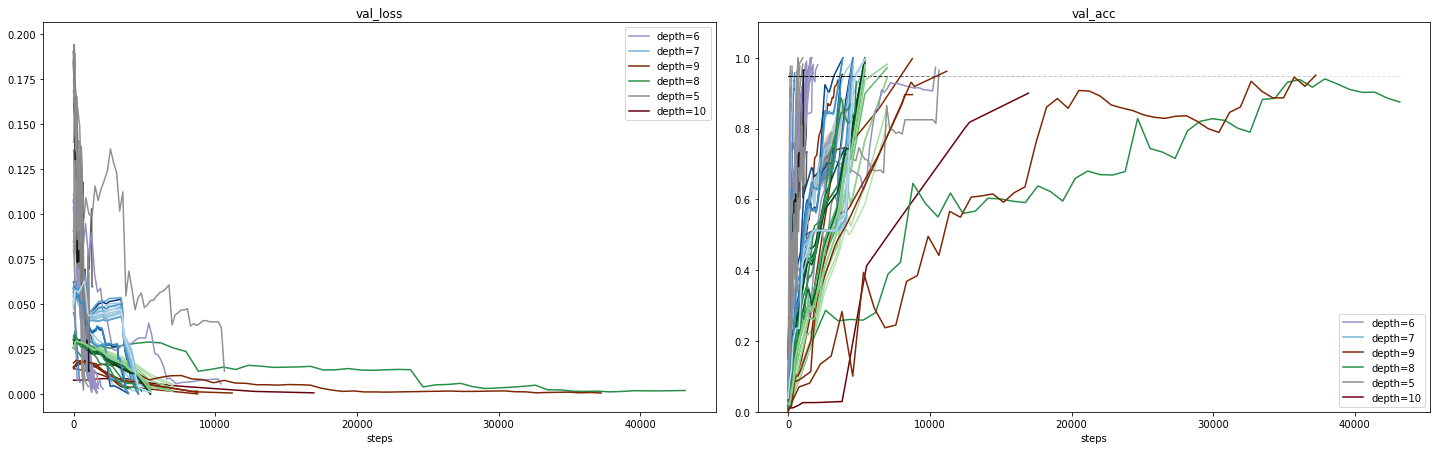

In [72]:
# loop over all files in directory

all_ckpt_dirs = os.listdir(LOG_PATH)
all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
#all_ckpt_dirs = [el for el in all_ckpt_dirs if el not in rejected_ckpts]
#all_ckpt_dirs = all_ckpt_dirs[:20]

logs_paths = [join(LOG_PATH,ckpt) for ckpt in all_ckpt_dirs]
print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                   all_ckpt_dirs, 
                                                   name="all_plots_>0.75", tot_num_values=50, 
                                                   plot_legend=2,
                                                   threshold=0.8)
plt.show()

In [73]:
highscore_table = sorted(highscore_table, key=lambda d: d['best_epoch'], reverse=False) 
highscore_table = sorted(highscore_table, key=lambda d: (d['best_score'], d['hidden_size']), reverse=True) 


print(highscore_table[0])

print_format_str = "{:<24} {:<4} {:<5} {:<7} {:<6} {:<4} {:<5}"

print('____________________________________________________')
print(print_format_str.format('name', 'lr', 'mode','h_size','#class', 'ep', 'best_score'))
for el in highscore_table:
    name=el['name']
    idx = [i for i in range(len(name)) if name.startswith('_', i)][3]
    name=name[idx+1:]
    print (print_format_str.format(name, el['lr'], el['mode'], el['hidden_size'], 
                                    el['nb_classes'], el['best_epoch'], el['best_score']))


{'b_len': 1, 'eval_steps': [], 'hidden_size': 2000, 'input_size': 200, 'lr': 2.0, 'lr_scheduler': None, 'max_batches_per_epoch': 1280, 'mode': 'um', 'nb_classes': 256, 'optimizer': 'sgd', 'best_epoch': 56, 'name': '27126667_2004_1500_synth_um_b1_d8_h2000_lr2.0', 'best_score': 1.0}
____________________________________________________
name                     lr   mode  h_size  #class ep   best_score
um_b1_d8_h2000_lr2.0     2.0  um    2000    256    56   1.0  
um_b1_d8_h600_lr2.0      2.0  um    600     256    112  1.0  
um_b1_d8_h400_lr5.0      5.0  um    400     256    59   1.0  
um_b1_d7_h400_lr5.0      5.0  um    400     128    77   1.0  
um_b1_d7_h400_lr3.0      3.0  um    400     128    110  1.0  
um_b1_d8_h300_lr10.0     10.0 um    300     256    55   1.0  
um_b1_d8_h300_lr5.0      5.0  um    300     256    59   1.0  
um_b1_d7_h300_lr3.0      3.0  um    300     128    80   1.0  
um_b1_d7_h250_lr2.0      2.0  um    250     128    143  1.0  
um_b1_d7_h250_lr10.0     10.0 um    250 

# Filtered graphs

#logged paths : 8 
27149290_2604_1439_synth_um_b0_d5_h25_lr2.0
fold_0 val_loss 124, val_acc 124, Max_acc: 0.637 val_epoch 124, 

27147221_2504_1612_synth_um_b0_d5_h25_lr2.0
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_epoch 456, 

27141008_2404_1749_synth_rand_b0_d5_h25_lr2.0
fold_2 val_loss 12, val_acc 12, Max_acc: 0.962 val_epoch 12, 
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 
fold_1 val_loss 14, val_acc 14, Max_acc: 0.966 val_epoch 14, 

27140968_2404_1655_synth_um_b1_d5_h25_lr2.0
fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 val_epoch 10, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 0.997 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27140969_2404_1655_synth_um_b10_d5_h25_lr2.0
fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 val_epoch 10, 
fold_2 val_loss 12, val_acc 12, Max_acc: 1.0 val_epoch 12, 
fold_0 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_1 val_loss 9, val_acc 

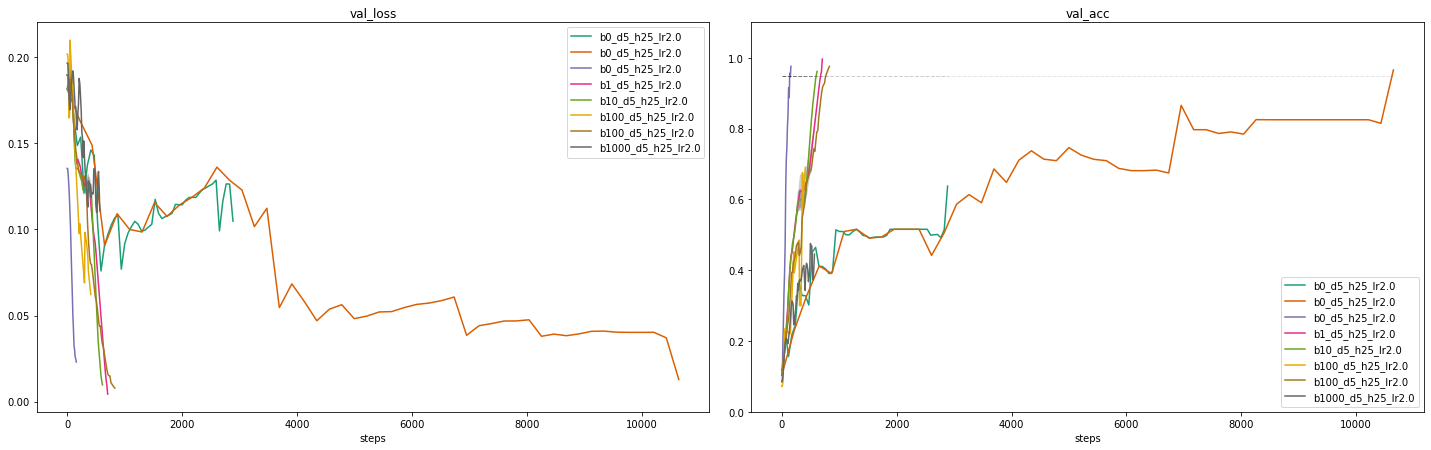

#logged paths : 6 
27146946_2504_1450_synth_rand_b0_d6_h25_lr5.0
fold_2 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 
fold_0 val_loss 28, val_acc 28, Max_acc: 0.97 val_epoch 28, 
fold_1 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 

27147223_2504_1612_synth_um_b0_d6_h25_lr5.0
fold_0 val_loss 323, val_acc 323, Max_acc: 0.973 val_epoch 323, 

27137826_2404_1154_synth_um_b1_d6_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_2 val_loss 8, val_acc 8, Max_acc: 0.962 val_epoch 8, 
fold_0 val_loss 11, val_acc 11, Max_acc: 0.981 val_epoch 11, 
fold_1 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 

27137827_2404_1154_synth_um_b10_d6_h25_lr5.0
fold_3 val_loss 10, val_acc 10, Max_acc: 0.992 val_epoch 10, 
fold_2 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_0 val_loss 12, val_acc 12, Max_acc: 0.977 val_epoch 12, 
fold_1 val_loss 12, val_acc 12, Max_acc: 1.0 val_epoch 12, 

27135060_2304_1750_synth_um_b100_d6_h25_lr5.0
fold_3 val_loss 18, val_a

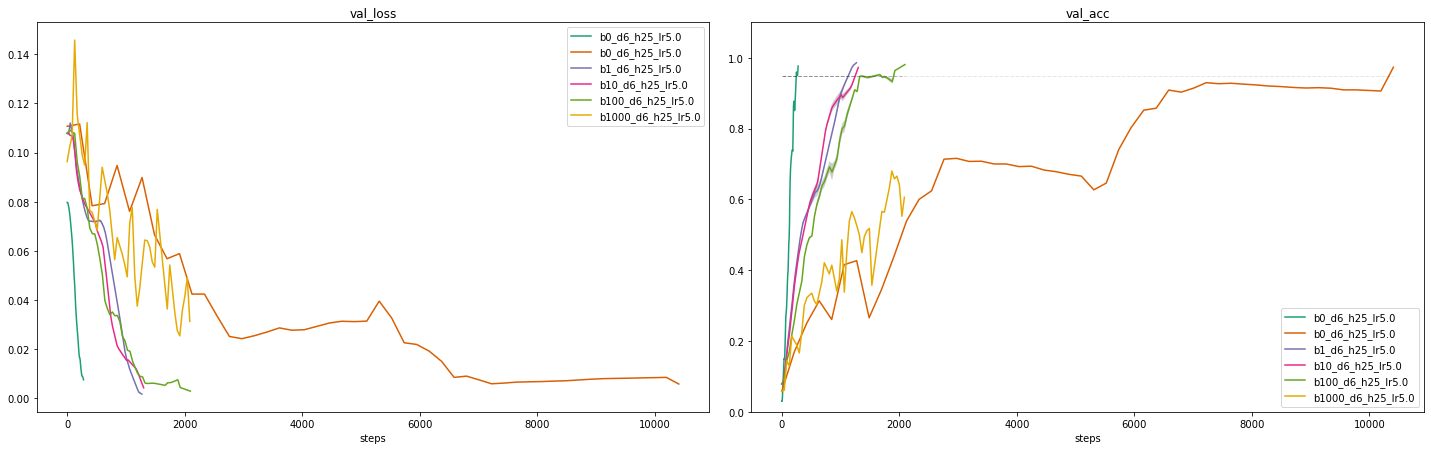

#logged paths : 4 
27146948_2504_1450_synth_rand_b0_d7_h250_lr5.0
fold_3 val_loss 45, val_acc 45, Max_acc: 0.952 val_epoch 45, 
fold_2 val_loss 43, val_acc 43, Max_acc: 0.952 val_epoch 43, 
fold_0 val_loss 44, val_acc 44, Max_acc: 0.954 val_epoch 44, 
fold_1 val_loss 46, val_acc 46, Max_acc: 0.971 val_epoch 46, 

27147225_2504_1613_synth_um_b0_d7_h250_lr5.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 

27127958_2104_1218_synth_um_b1_d7_h250_lr5.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.997 val_epoch 23, 

27135067_2304_1752_synth_um_b10_d7_h250_lr5.0
fold_0 val_loss 25, val_acc 25, Max_acc: 0.989 val_epoch 25, 
fold_1 val_loss 20, val_acc 20, Max_acc: 0.86 val_epoch 20, 



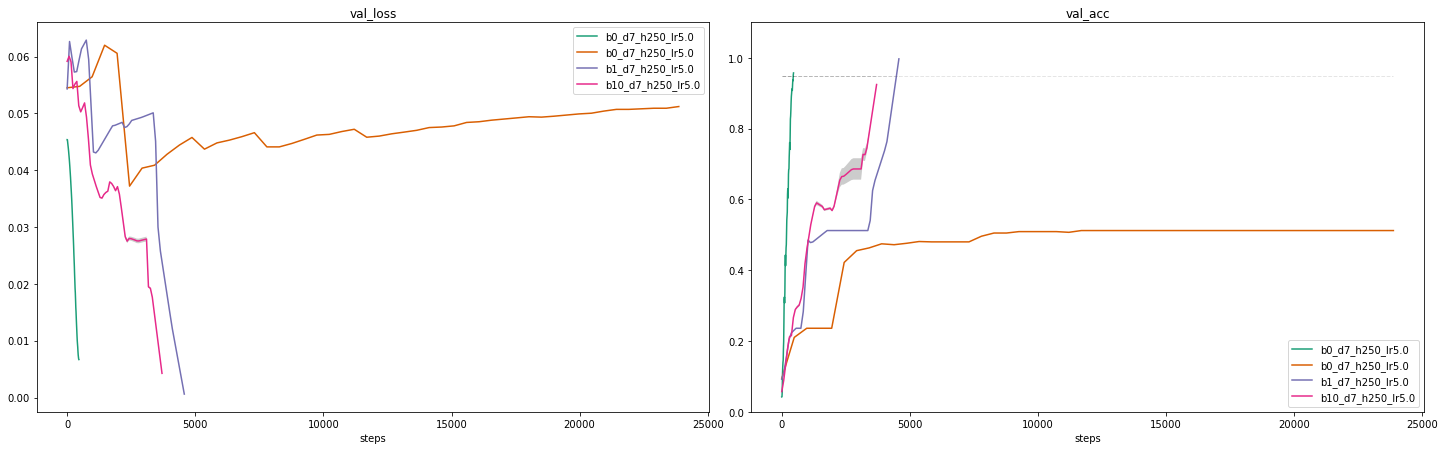

#logged paths : 6 
27146950_2504_1451_synth_rand_b0_d8_h300_lr5.0
fold_3 val_loss 123, val_acc 123, Max_acc: 0.952 val_epoch 123, 
fold_2 val_loss 121, val_acc 121, Max_acc: 0.952 val_epoch 121, 
fold_0 val_loss 125, val_acc 125, Max_acc: 0.953 val_epoch 125, 
fold_1 val_loss 131, val_acc 131, Max_acc: 0.97 val_epoch 131, 

27147228_2504_1617_synth_um_b0_d8_h300_lr5.0
fold_0 val_loss 972, val_acc 972, Max_acc: 0.947 val_epoch 972, 

27127994_2104_1329_synth_um_b1_d8_h300_lr5.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27137832_2404_1155_synth_um_b10_d8_h300_lr5.0
fold_2 val_loss 15, val_acc 15, Max_acc: 0.877 val_epoch 15, 
fold_0 val_loss 17, val_acc 17, Max_acc: 1.0 val_epoch 17, 
fold_1 val_loss 13, val_acc 13, Max_acc: 0.951 val_epoch 13, 

27137833_2404_1155_synth_um_b100_d8_h300_lr5.0
fold_0 val_loss 30, val_acc 30, Max_acc: 0.933 val_epoch 30, 

27137834_2404_1155_synth_um_b1000_d8_h300_lr5.0
fold_0 val_loss 49, val_acc 49, Max_acc: 0.625 val_epoch 49, 



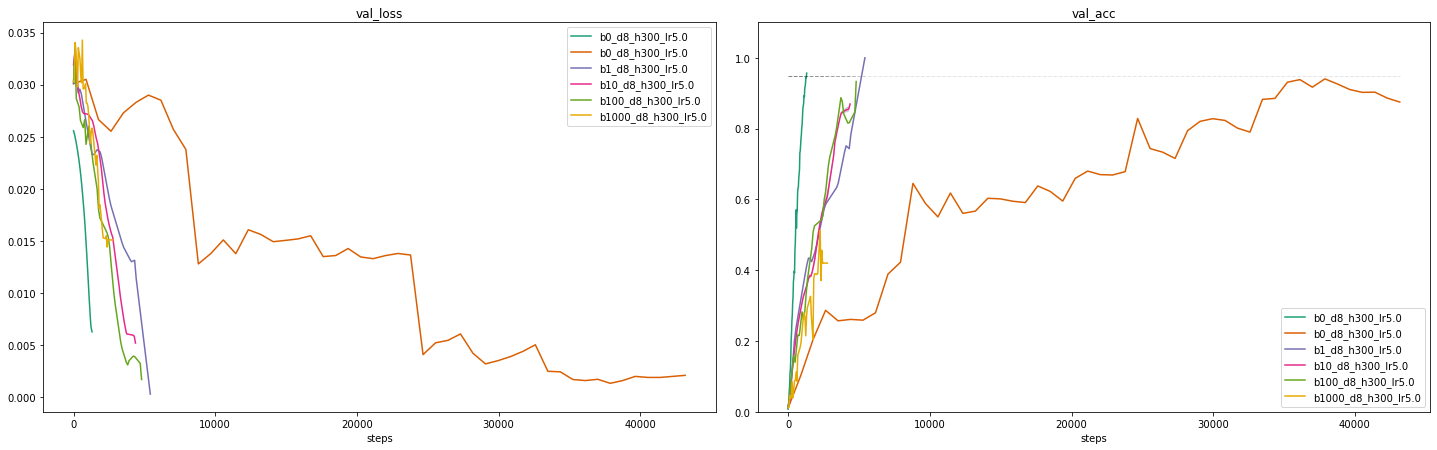

#logged paths : 7 
27127963_2104_1218_synth_um_b1_d9_h500_lr10.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.998 val_epoch 11, 

27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
fold_3 val_loss 378, val_acc 378, Max_acc: 0.951 val_epoch 378, 
fold_2 val_loss 335, val_acc 335, Max_acc: 0.954 val_epoch 335, 
fold_0 val_loss 382, val_acc 382, Max_acc: 0.953 val_epoch 382, 
fold_1 val_loss 376, val_acc 376, Max_acc: 0.956 val_epoch 376, 

27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
fold_0 val_loss 570, val_acc 570, Max_acc: 0.951 val_epoch 570, 

27127962_2104_1218_synth_um_b1_d9_h500_lr5.0
fold_0 val_loss 13, val_acc 13, Max_acc: 0.962 val_epoch 13, 

27127800_2104_0802_synth_um_b1_d9_h500_lr2.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.667 val_epoch 12, 

27127799_2104_0800_synth_um_b1_d9_h500_lr1.5
fold_0 val_loss 12, val_acc 12, Max_acc: 0.491 val_epoch 12, 

27127798_2104_0800_synth_um_b1_d9_h500_lr1.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.386 val_epoch 12, 



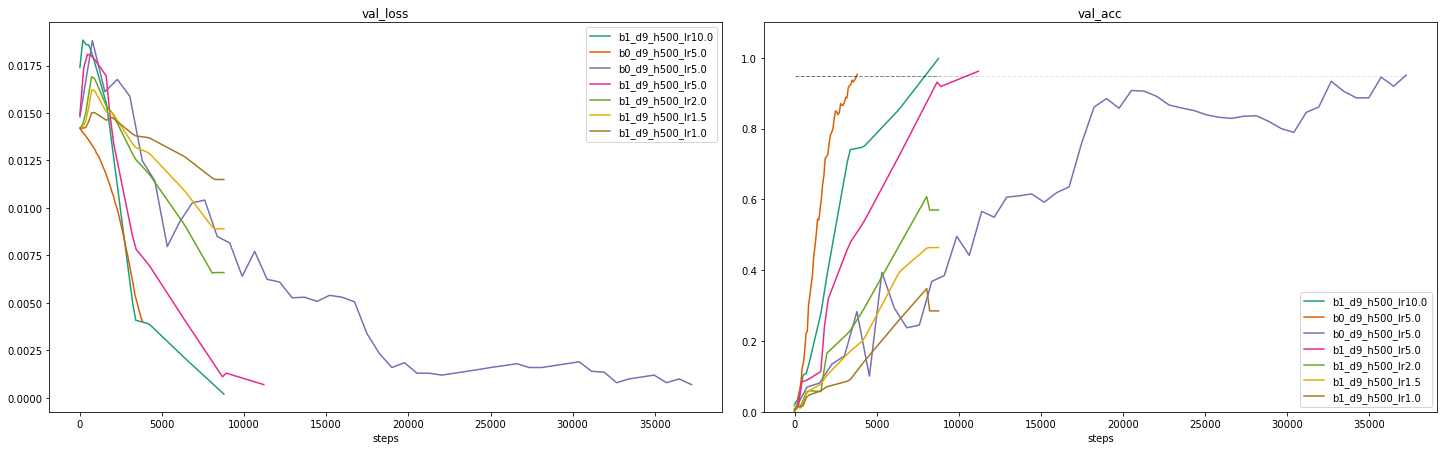

#logged paths : 5 
27146955_2504_1451_synth_rand_b0_d10_h1000_lr5.0
fold_0 val_loss 787, val_acc 787, Max_acc: 0.951 val_epoch 787, 
fold_1 val_loss 348, val_acc 348, Max_acc: 0.64 val_epoch 348, 

27127999_2104_1331_synth_um_b1_d10_h1000_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.9 val_epoch 10, 

27127998_2104_1331_synth_um_b1_d10_h1000_lr2.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.581 val_epoch 10, 

27127830_2104_1012_synth_um_b1_d10_h1000_lr1.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.429 val_epoch 10, 

27127829_2104_1012_synth_um_b1_d10_h1000_lr0.5
fold_0 val_loss 10, val_acc 10, Max_acc: 0.147 val_epoch 10, 



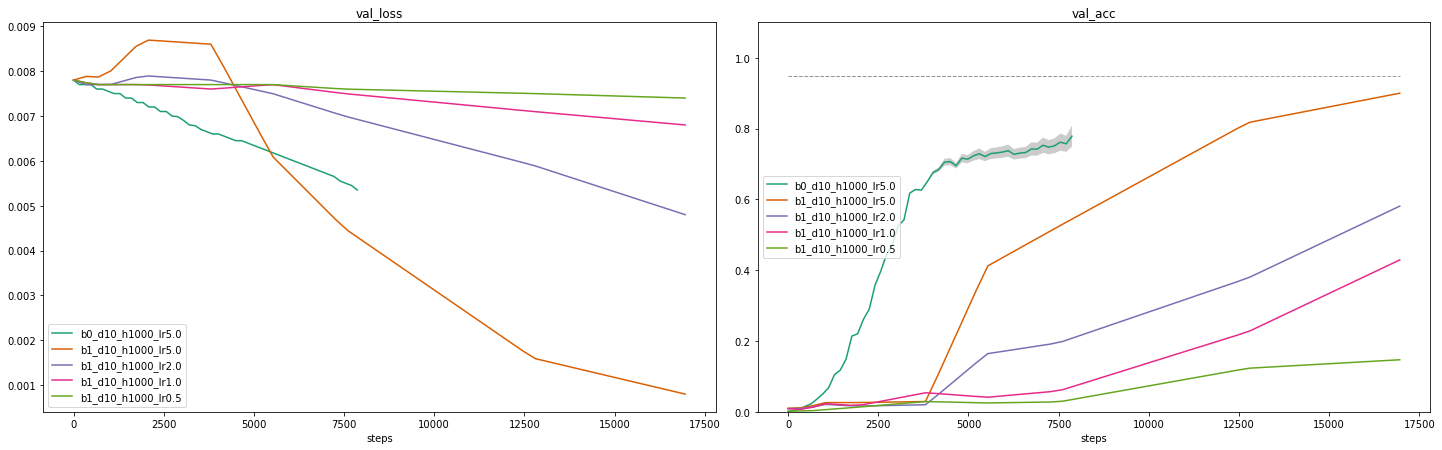

In [68]:
# example name: 27135056_2304_1747_synth_um_b1000_d5_h25_lr5


def plot_runs_w_regex(re_patt_to_search, threshold):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir("../logs/")
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]*)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]*)', d).group(1)), reverse=True)

    logs_paths = [f"../logs/{ckpt}/" for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                       all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=50, 
                                                       plot_legend=1,
                                                       threshold=threshold, color_patt='discrete')
    plt.show()

patts_to_search = ["d5_h25_lr2", "d6_h25_lr5",  "d7_h250_lr5", "d8_h300_lr5", "d9_h500", "d10_h1000"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.1) 


In [ ]:
# Temp

#logged paths : 5 
27146929_2504_1440_synth_um_b1_d5_h25_lr10.0
fold_0 val_loss 34, val_acc 34, Max_acc: 0.0906 unsuccessful run
27137821_2404_1154_synth_um_b1_d5_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 0.981 val_epoch 9, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 1.0 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27140968_2404_1655_synth_um_b1_d5_h25_lr2.0
fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 val_epoch 10, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 0.997 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27146928_2504_1440_synth_um_b1_d5_h25_lr1.0
fold_3 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27146927_2504_1440_synth_um_b1

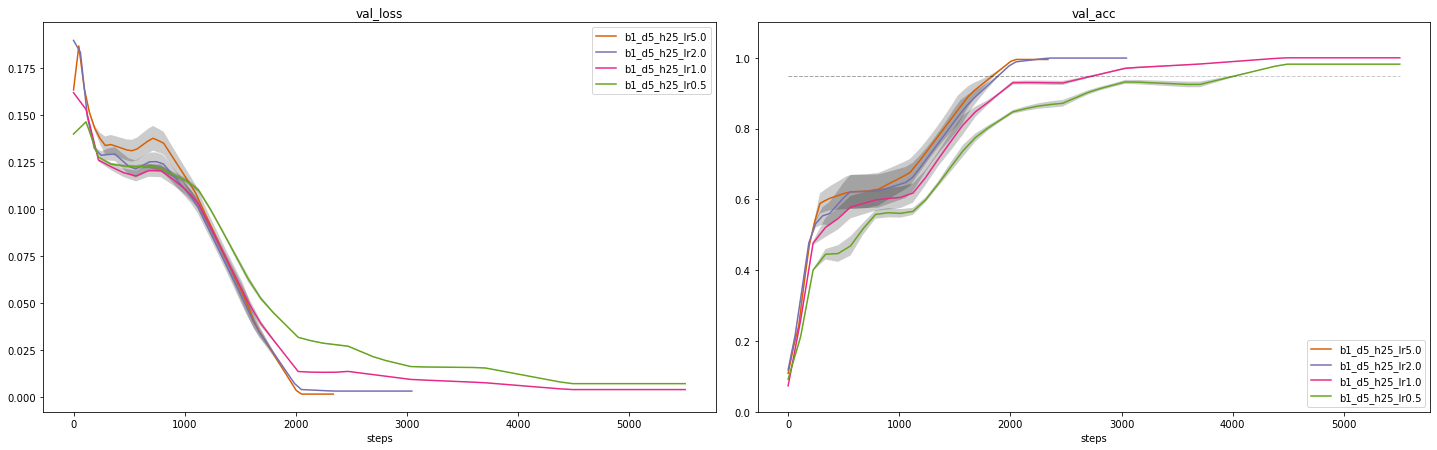

#logged paths : 2 
27137826_2404_1154_synth_um_b1_d6_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_2 val_loss 8, val_acc 8, Max_acc: 0.962 val_epoch 8, 
fold_0 val_loss 11, val_acc 11, Max_acc: 0.981 val_epoch 11, 
fold_1 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 

27127858_2104_1119_synth_um_b1_d6_h25_lr3.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.952 val_epoch 11, 



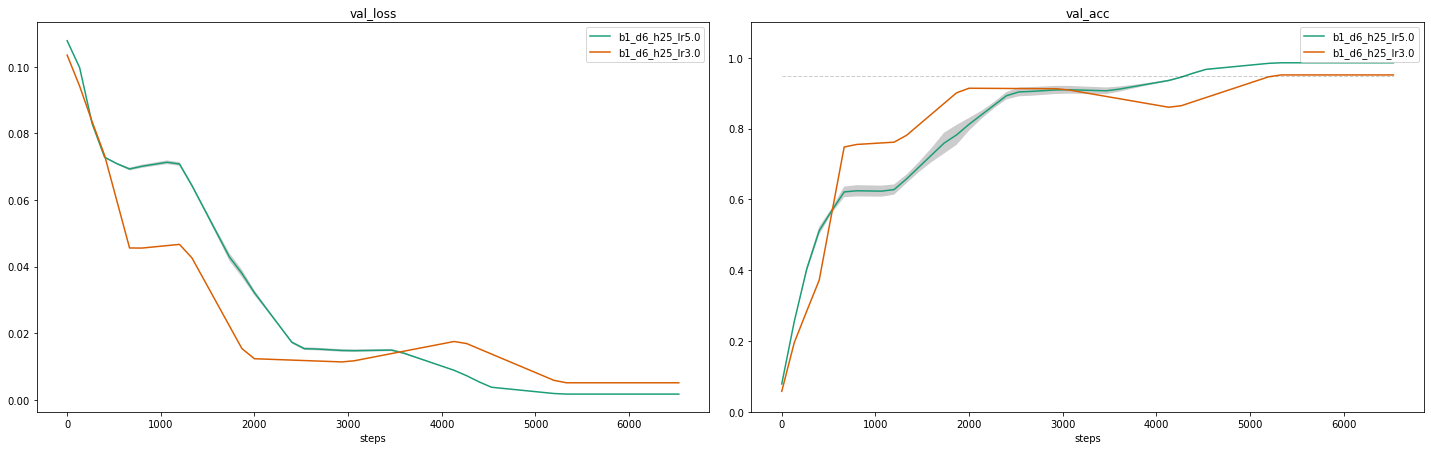

#logged paths : 8 
27127959_2104_1218_synth_um_b1_d7_h250_lr10.0
fold_0 val_loss 23, val_acc 23, Max_acc: 1.0 val_epoch 23, 

27127958_2104_1218_synth_um_b1_d7_h250_lr5.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.997 val_epoch 23, 

27127880_2104_1127_synth_um_b1_d7_h250_lr3.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.977 val_epoch 23, 

27146496_2504_1409_synth_um_b1_d7_h250_lr2.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.941 val_epoch 23, 

27127879_2104_1127_synth_um_b1_d7_h250_lr2.0
fold_0 val_loss 24, val_acc 24, Max_acc: 1.0 val_epoch 24, 

27146498_2504_1409_synth_um_b1_d7_h250_lr2.0
fold_2 val_loss 12, val_acc 12, Max_acc: 0.985 val_epoch 12, 

27146497_2504_1409_synth_um_b1_d7_h250_lr2.0
fold_1 val_loss 20, val_acc 20, Max_acc: 0.986 val_epoch 20, 

27127785_2104_0758_synth_um_b1_d7_h250_lr1.5
fold_0 val_loss 23, val_acc 23, Max_acc: 0.93 val_epoch 23, 



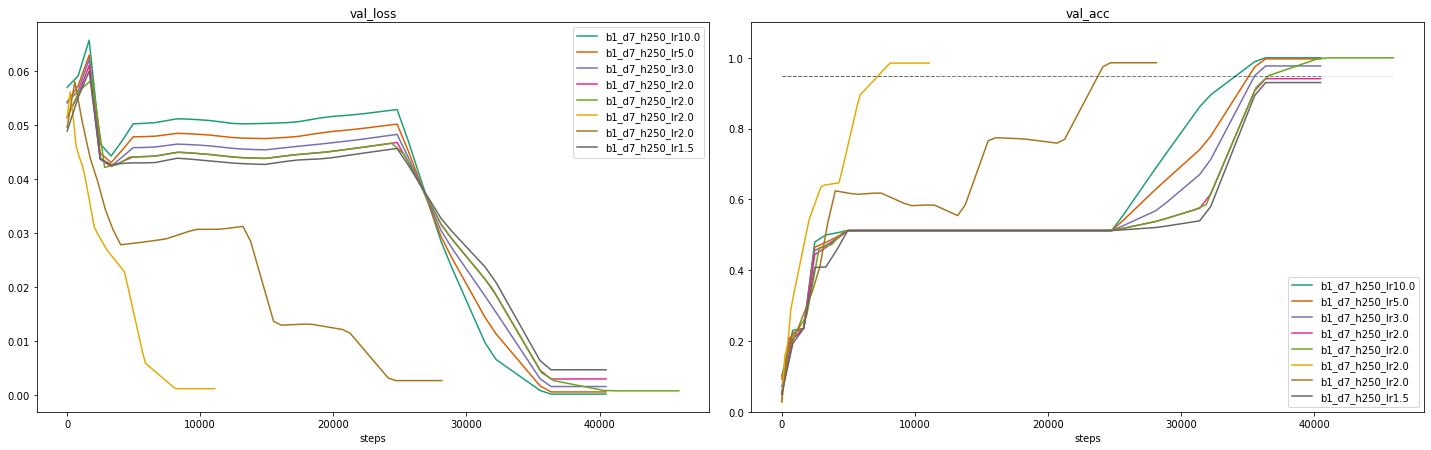

#logged paths : 4 
27147181_2504_1534_synth_um_b1_d8_h300_lr10.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27127994_2104_1329_synth_um_b1_d8_h300_lr5.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27127993_2104_1329_synth_um_b1_d8_h300_lr2.0
fold_0 val_loss 16, val_acc 16, Max_acc: 0.98 val_epoch 16, 

27147180_2504_1527_synth_um_b1_d8_h300_lr1.0
fold_0 val_loss 17, val_acc 17, Max_acc: 0.812 val_epoch 17, 



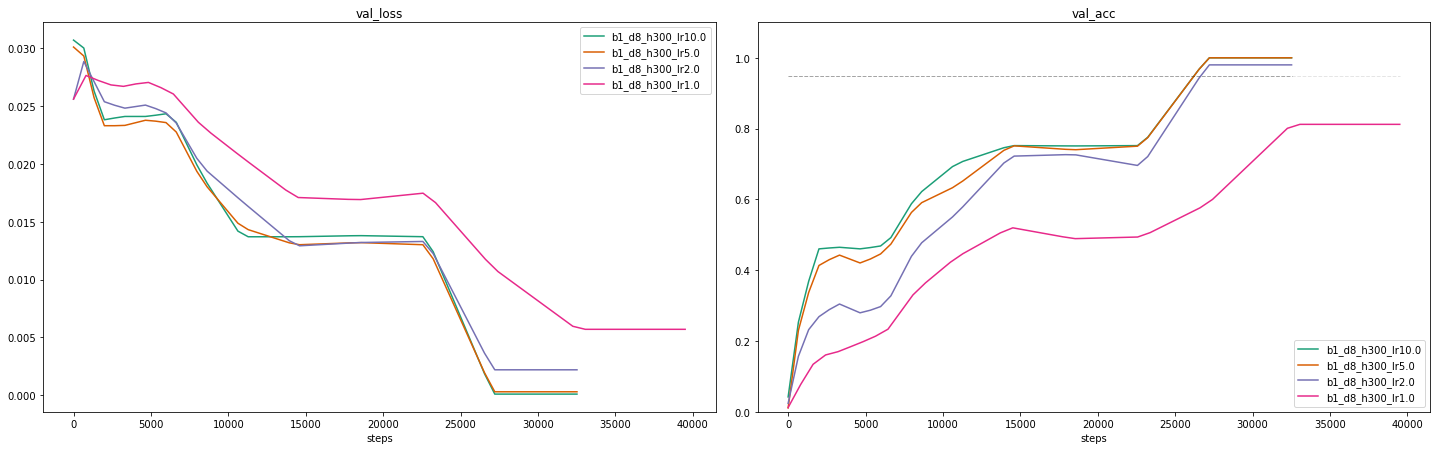

#logged paths : 5 
27127963_2104_1218_synth_um_b1_d9_h500_lr10.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.998 val_epoch 11, 

27127962_2104_1218_synth_um_b1_d9_h500_lr5.0
fold_0 val_loss 13, val_acc 13, Max_acc: 0.962 val_epoch 13, 

27127800_2104_0802_synth_um_b1_d9_h500_lr2.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.667 val_epoch 12, 

27127799_2104_0800_synth_um_b1_d9_h500_lr1.5
fold_0 val_loss 12, val_acc 12, Max_acc: 0.491 val_epoch 12, 

27127798_2104_0800_synth_um_b1_d9_h500_lr1.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.386 val_epoch 12, 



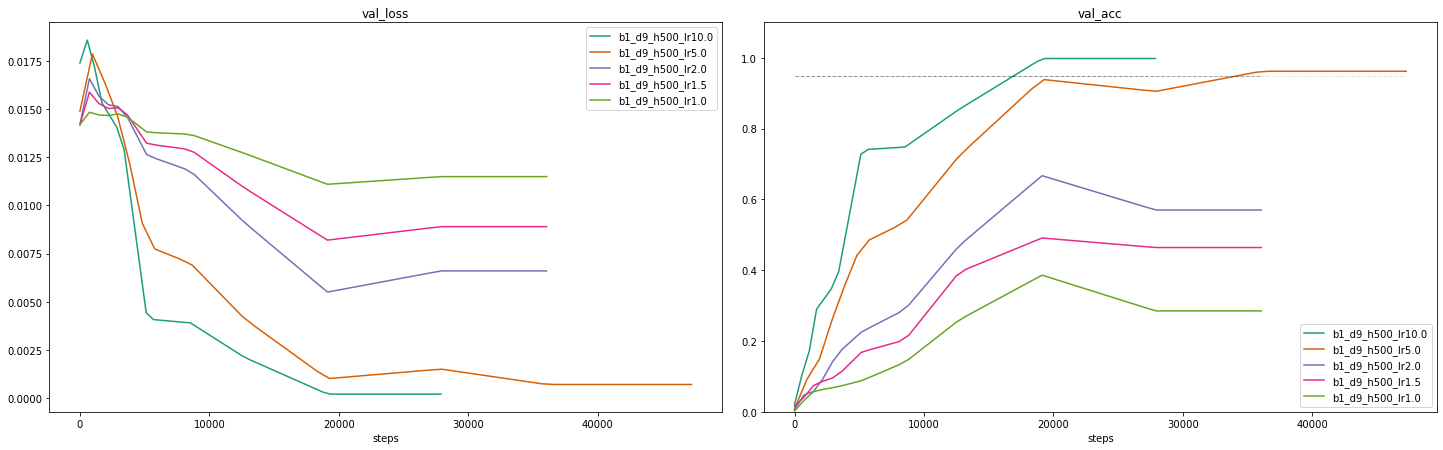

#logged paths : 5 
27146955_2504_1451_synth_rand_b0_d10_h1000_lr5.0
fold_0 val_loss 787, val_acc 787, Max_acc: 0.951 val_epoch 787, 
fold_1 val_loss 348, val_acc 348, Max_acc: 0.64 val_epoch 348, 

27127999_2104_1331_synth_um_b1_d10_h1000_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.9 val_epoch 10, 

27127998_2104_1331_synth_um_b1_d10_h1000_lr2.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.581 val_epoch 10, 

27127830_2104_1012_synth_um_b1_d10_h1000_lr1.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.429 val_epoch 10, 

27127829_2104_1012_synth_um_b1_d10_h1000_lr0.5
fold_0 val_loss 10, val_acc 10, Max_acc: 0.147 val_epoch 10, 



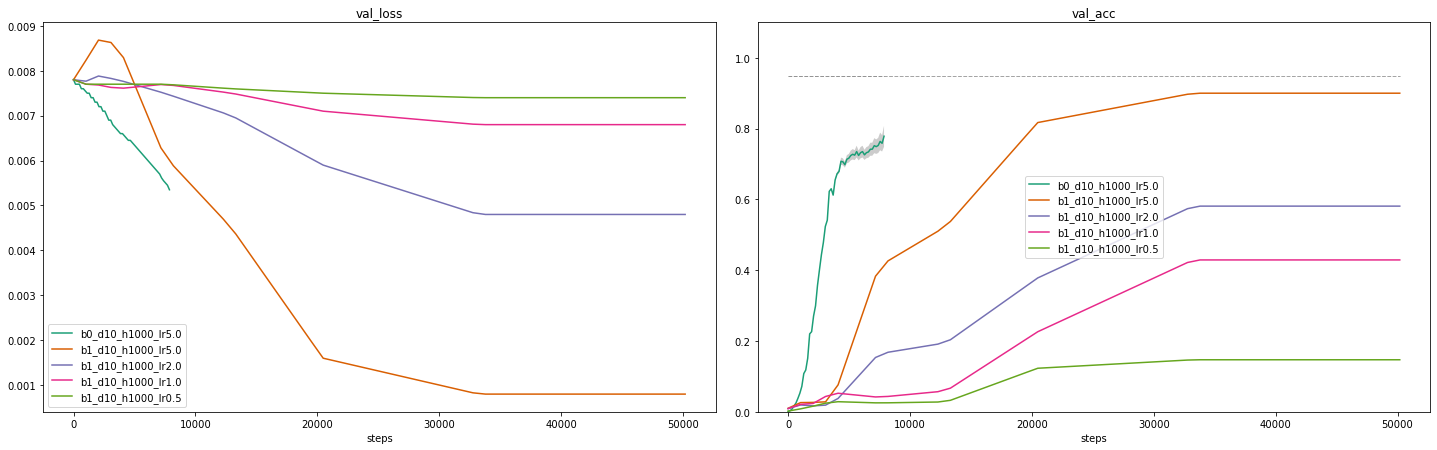

In [38]:
patts_to_search = ["b1_d5_h25_lr", "b1_d6_h25_lr",  "b1_d7_h250_lr", "b1_d8_h300_lr", "b1_d9_h500_lr", "d10_h1000"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.1) 

#logged paths : 25 
27135055_2304_1747_synth_um_b100_d5_h25_lr5.0
fold_0 val_loss 28, val_acc 28, Max_acc: 0.172 unsuccessful run
27137823_2404_1154_synth_um_b100_d5_h25_lr5.0
fold_3 val_loss 27, val_acc 27, Max_acc: 0.206 unsuccessful run
27128035_2104_1442_synth_um_b1000_d5_h100_lr5.0
fold_0 val_loss 36, val_acc 36, Max_acc: 0.434 unsuccessful run
27137824_2404_1154_synth_um_b1000_d5_h25_lr5.0
fold_3 val_loss 39, val_acc 39, Max_acc: 0.275 unsuccessful run
27147174_2504_1518_synth_um_b1000_d5_h100_lr5.0
fold_0 val_loss 32, val_acc 32, Max_acc: 0.387 unsuccessful run
27135056_2304_1747_synth_um_b1000_d5_h25_lr5.0
fold_0 val_loss 30, val_acc 30, Max_acc: 0.184 unsuccessful run
27128004_2104_1334_synth_um_b1000_d5_h50_lr5.0
fold_0 val_loss 38, val_acc 38, Max_acc: 0.334 unsuccessful run
27135034_2304_1737_synth_um_b1000_d5_h400_lr5.0
fold_0 val_loss 50, val_acc 50, Max_acc: 0.641 unsuccessful run
27128038_2104_1442_synth_um_b1000_d5_h200_lr5.0
fold_0 val_loss 44, val_acc 44, Max_acc: 0.

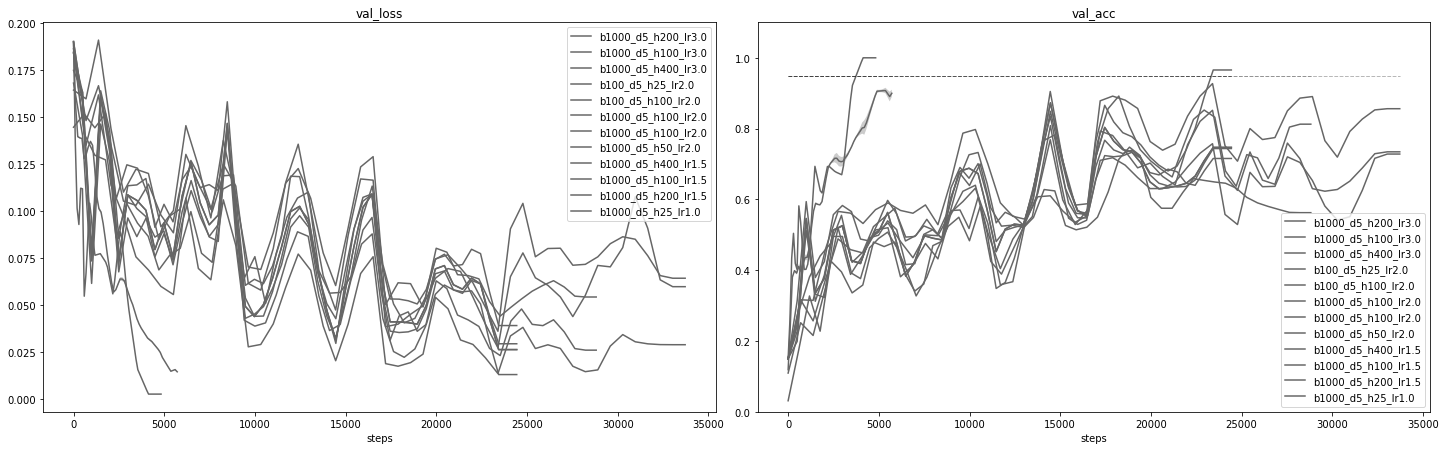

#logged paths : 7 
27135041_2304_1737_synth_um_b1000_d6_h100_lr5.0
fold_0 val_loss 35, val_acc 35, Max_acc: 0.681 unsuccessful run
27147176_2504_1519_synth_um_b1000_d6_h100_lr5.0
fold_0 val_loss 35, val_acc 35, Max_acc: 0.681 unsuccessful run
27135040_2304_1737_synth_um_b1000_d6_h100_lr3.0
fold_0 val_loss 40, val_acc 40, Max_acc: 0.711 unsuccessful run
27126696_2004_1530_synth_um_b10_d6_h100_lr2.0
fold_0 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 

27147175_2504_1519_synth_um_b1000_d6_h100_lr2.0
fold_0 val_loss 40, val_acc 40, Max_acc: 0.705 unsuccessful run
27127145_2004_1850_synth_um_b1_d6_h100_lr1.5
fold_0 val_loss 12, val_acc 12, Max_acc: 1.0 val_epoch 12, 

27135039_2304_1737_synth_um_b1000_d6_h100_lr1.5
fold_0 val_loss 40, val_acc 40, Max_acc: 0.667 unsuccessful run


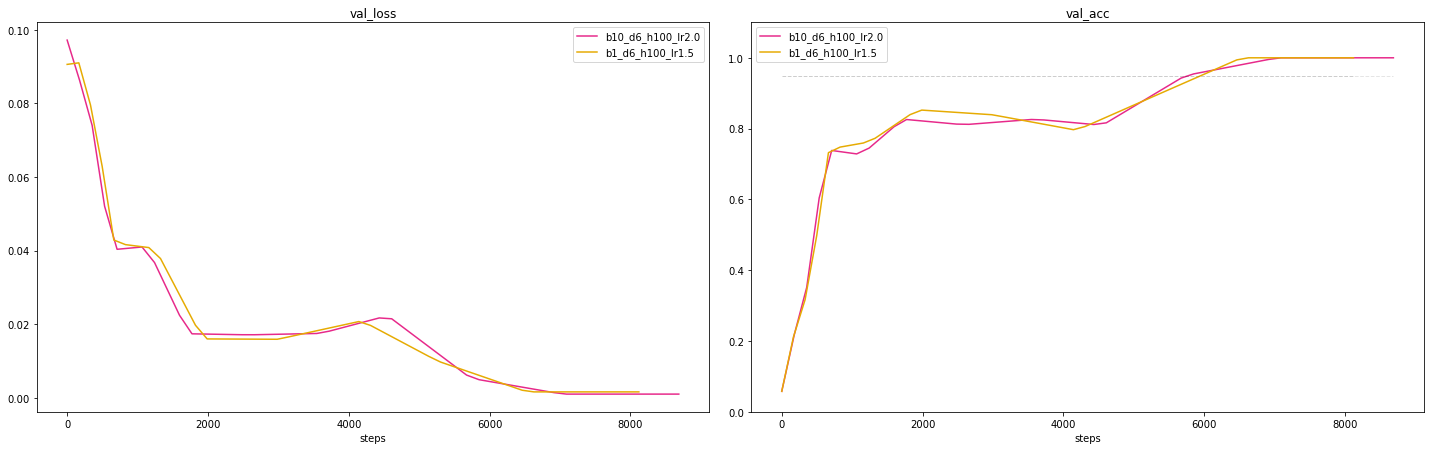

#logged paths : 1 
27127865_2104_1119_synth_um_b1000_d5_h25_lr1.0
fold_0 val_loss 48, val_acc 48, Max_acc: 0.769 val_epoch 48, 



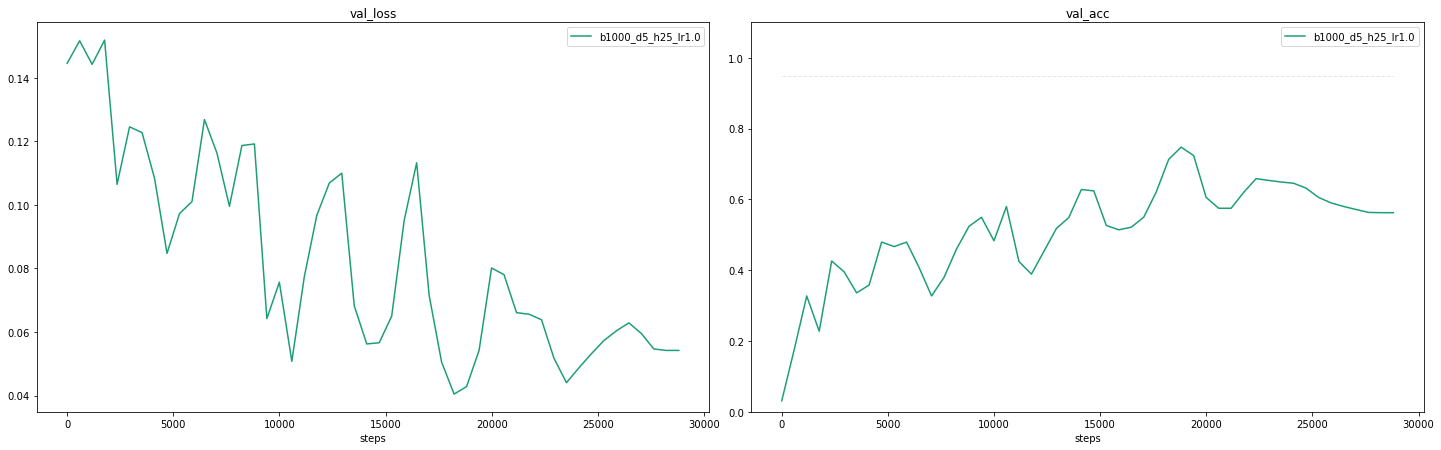

In [47]:
patts_to_search = ["b1000*_d5_h", "d6_h100_lr", "27127865"]
for patt in patts_to_search: plot_runs_w_regex(patt, 0.75) 

#logged paths : 5 
27149295_2604_1445_synth_um_b1000_d5_h50_lr2.0
fold_0 val_loss 1, unsuccessful run
27140971_2404_1655_synth_um_b1000_d5_h25_lr2.0
fold_2 val_loss 24, val_acc 24, Max_acc: 0.572 val_epoch 24, 
fold_0 val_loss 48, val_acc 48, Max_acc: 0.75 val_epoch 48, 
fold_1 val_loss 49, val_acc 49, Max_acc: 0.637 val_epoch 49, 

27147173_2504_1517_synth_um_b1000_d5_h100_lr2.0
fold_0 val_loss 44, val_acc 44, Max_acc: 0.884 val_epoch 44, 

27146425_2504_1154_synth_um_b1000_d5_h100_lr2.0
fold_0 val_loss 44, val_acc 44, Max_acc: 0.884 val_epoch 44, 

27127867_2104_1119_synth_um_b1000_d5_h50_lr2.0
fold_0 val_loss 44, val_acc 44, Max_acc: 0.822 val_epoch 44, 



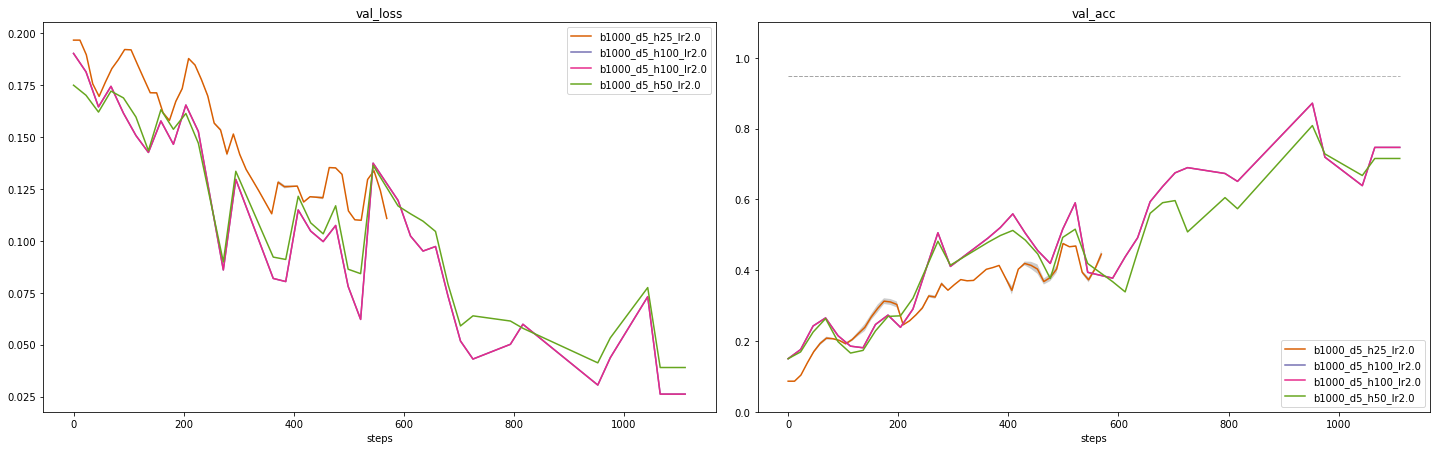

#logged paths : 8 
27149336_2604_1539_synth_um_b0_d7_h250_lr10.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 

27149337_2604_1539_synth_um_b0_d7_h250_lr10.0
fold_1 val_loss 1351, val_acc 1351, Max_acc: 0.922 val_epoch 1351, 

27146948_2504_1450_synth_rand_b0_d7_h250_lr5.0
fold_3 val_loss 45, val_acc 45, Max_acc: 0.952 val_epoch 45, 
fold_2 val_loss 43, val_acc 43, Max_acc: 0.952 val_epoch 43, 
fold_0 val_loss 44, val_acc 44, Max_acc: 0.954 val_epoch 44, 
fold_1 val_loss 46, val_acc 46, Max_acc: 0.971 val_epoch 46, 

27147225_2504_1613_synth_um_b0_d7_h250_lr5.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 val_epoch 763, 

27149335_2604_1533_synth_um_b0_d7_h250_lr2.0
fold_1 val_loss 1142, val_acc 1142, Max_acc: 0.906 val_epoch 1142, 

27149334_2604_1533_synth_um_b0_d7_h250_lr2.0
fold_0 val_loss 647, val_acc 647, Max_acc: 0.512 val_epoch 647, 

27149333_2604_1532_synth_um_b0_d7_h250_lr1.0
fold_1 val_loss 1142, val_acc 1142, Max_acc: 0.906 val_epoch 1142, 

27149332

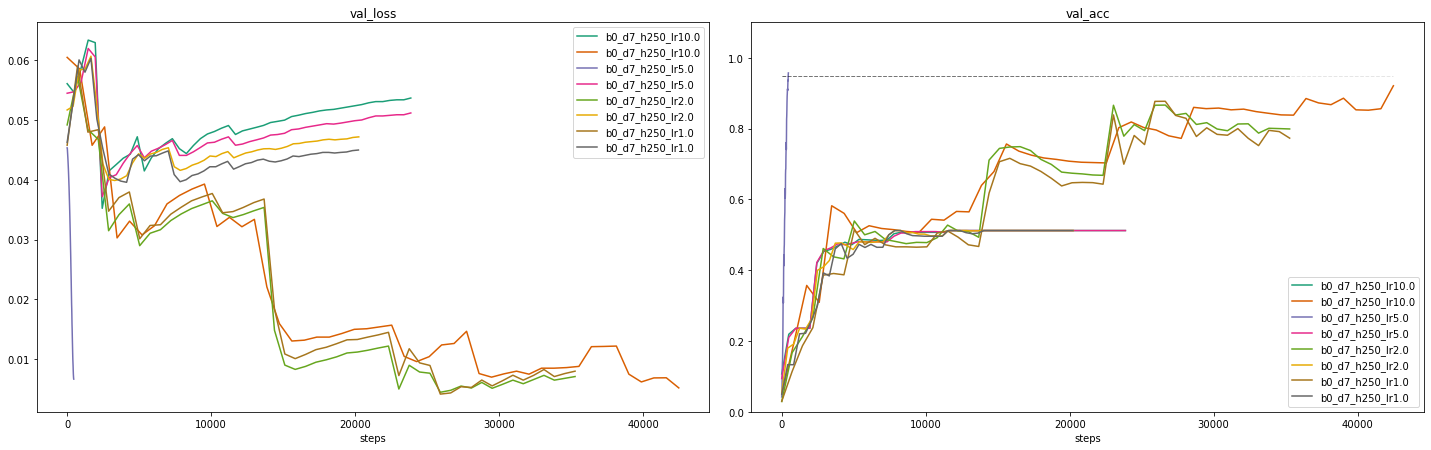

In [80]:

patts_to_search = ["b1000_d5_h[0-9]*_lr2", "b0_d7_h250"]
for patt in patts_to_search: plot_runs_w_regex(patt, 0.1) 

# Log folds merger

In [39]:
import shutil

def merge_folds(re_patt_to_search):
    all_ckpt_dirs = os.listdir(LOG_PATH)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    all_ckpt_dirs = [join(LOG_PATH, el, 'metrics') for el in all_ckpt_dirs]
    for el in all_ckpt_dirs: assert(os.path.isdir(el))
    
    print(f'Logs from {all_ckpt_dirs} will be merged, {len(all_ckpt_dirs)} folds')
    destination_folder = all_ckpt_dirs[0]
    print(f'Destination_folder: {destination_folder}')
    
    for path_fold in all_ckpt_dirs[1:]: 
        folder = os.listdir(path_fold)
        folder = [el for el in folder if "DS_Store" not in el]
        folder = join(path_fold, folder[0])
        shutil.move(folder, destination_folder)
        folder = folder[:folder[:folder.rfind('/')].rfind('/')]
        shutil.rmtree(folder)
    
patterns = ['2504_14[0-9]*_synth_um_b1000_d7_h250_lr2', '2504_14[0-9]*_synth_um_b100_d7_h250_lr2', '2504_14[0-9]*_synth_um_b1_d7_h250_lr2', '2504_14[0-9]*_synth_um_b10_d7_h250_lr2']
for patt in patterns: merge_folds(patt)


Logs from ['../logs/27146505_2504_1416_synth_um_b1000_d7_h250_lr2.0/metrics', '../logs/27146506_2504_1416_synth_um_b1000_d7_h250_lr2.0/metrics', '../logs/27146507_2504_1416_synth_um_b1000_d7_h250_lr2.0/metrics'] will be merged, 3 folds
Destination_folder: ../logs/27146505_2504_1416_synth_um_b1000_d7_h250_lr2.0/metrics
Logs from ['../logs/27146504_2504_1416_synth_um_b100_d7_h250_lr2.0/metrics', '../logs/27146503_2504_1415_synth_um_b100_d7_h250_lr2.0/metrics', '../logs/27146502_2504_1415_synth_um_b100_d7_h250_lr2.0/metrics'] will be merged, 3 folds
Destination_folder: ../logs/27146504_2504_1416_synth_um_b100_d7_h250_lr2.0/metrics
Logs from ['../logs/27146496_2504_1409_synth_um_b1_d7_h250_lr2.0/metrics', '../logs/27146498_2504_1409_synth_um_b1_d7_h250_lr2.0/metrics', '../logs/27146497_2504_1409_synth_um_b1_d7_h250_lr2.0/metrics'] will be merged, 3 folds
Destination_folder: ../logs/27146496_2504_1409_synth_um_b1_d7_h250_lr2.0/metrics
Logs from ['../logs/27146501_2504_1415_synth_um_b10_d7_h

In [ ]:
# TEST SPACE

In [51]:
def shuffle_blocks_v2(chain, b_len):
    shuff_chain = chain.copy() #bc we modifiy in-place afterward
    blocks = [shuff_chain[i:i+b_len] for i in range(0,len(shuff_chain),b_len)]
    np.random.shuffle(blocks)
    shuff_chain[:] = [b for bs in blocks for b in bs]
    return shuff_chain

c=[0,1,1,0,1,0,2,0,2,0,1,0,0,1,0,1]
print(len(c))
b=4
shuffle_blocks_v2(c, b)

16


[1, 0, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 0]